## Exploratory Data Analysis

This project utilises the **Wine** dataset, which is a 178 sample dataset that categorises 3 different types of Italian wine using 13 different features. The code below loads the Wine dataset and selects a subset of features.

In [48]:
from sklearn import datasets 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statistics as st

In [ ]:
# Load data
wine=datasets.load_wine()

# Select a subset of the dataset's 13 features
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names )
selected_features = ['alcohol','flavanoids','color_intensity','ash']

# Extract the data as numpy arrays of features, X, and target, y
X = df_wine[selected_features].values
y = wine.target

## Visualising the data

Since there are only a small number of classes and features, it is possible to use scatter plots to visualise interactions between different pairings of features.
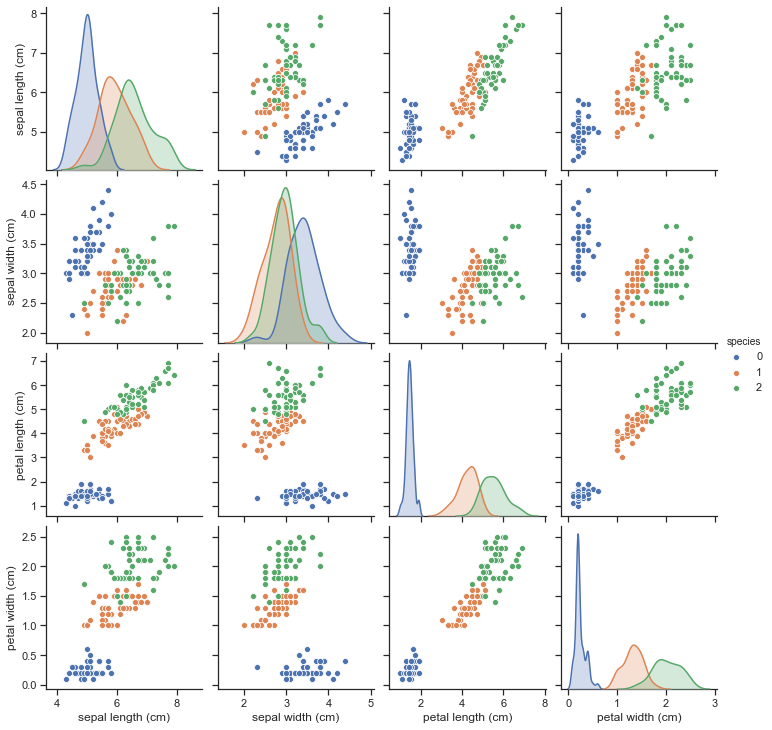

In [50]:
# Define plotting function
def myplotGrid(X,y):
    """Generates scatter (off-diagonal) plots and KDE plots (diagonal) for a given set of observations

    Parameters
    ----------
    X : numpy.ndarray
        The feature set
    y : numpy.ndarray
        The labels corresponding with the feature set

    """
    df = pd.DataFrame(X, columns=selected_features)
    g = sns.PairGrid(df)
    g.map_offdiag(sns.scatterplot, hue=y)
    g.map_diag(sns.kdeplot, hue=y, fill=True)

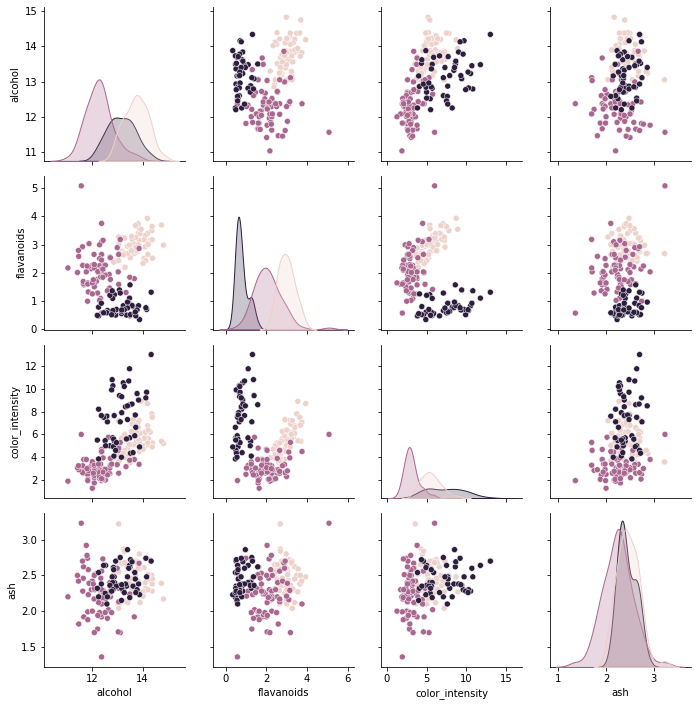

In [51]:
# Run the plotting function
myplotGrid(X,y)

### Exploratory Data Analysis under noise

In the real-world, data usually contains some amount of noise that makes classification more challenging. Here, a noisy version of the dataset is created for testing our algorithms below.

In [52]:
random_seed = 12345 
np.random.seed(random_seed) 
XN=X+np.random.normal(0,0.5,X.shape)

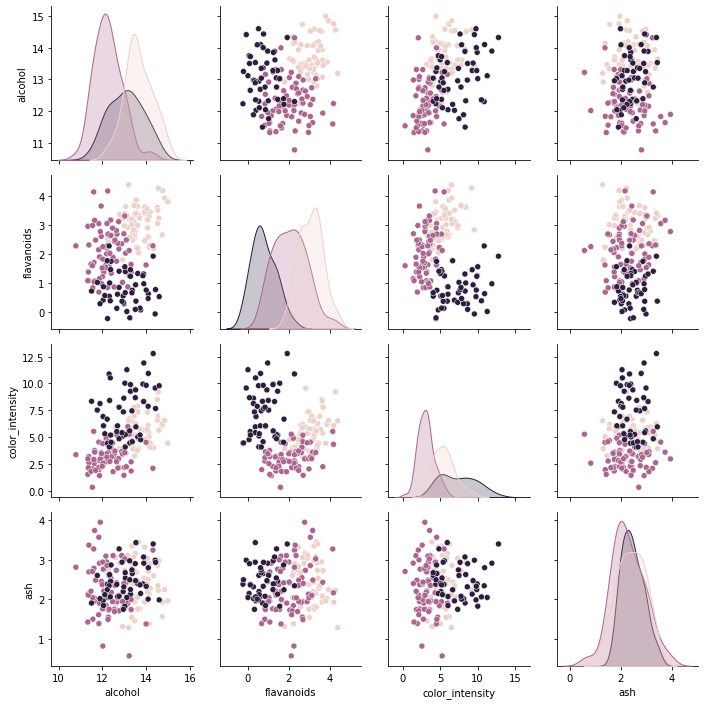

In [53]:
# Plot noisy data
myplotGrid(XN,y)

The plots above can help with feature selection. If we were to look for the best subset of the set of features, that is the dimensions or features that give us the most information, we can look at the plots for each single feature (the diagonal plots). The two features that, by themselves, allow the best discrimination between the three classes are alcohol and flavanoids. This is reflected in the plots showing alcohol on the y-axis and flavanoids on the x-axis (plot 1-2) and flavanoids on the y-axis and alcohol on the x-axis (plot 2-1) where the three classes form relatively distinct clusters.

For noisy datasets, this becomes a lot more difficult to separate the classes visually as the class boundaries are fuzzier. Any formerly visible clusters appear much less dense as the data points are spread out more, which leads to a high degree of overlap between the classes.

## Implementing kNN from Scratch

In [64]:
def split_train_test(X, y, test_size, random_seed):
    """Generates a set of training and testing data from a given feature set and it's correspponding labels

    Parameters
    ----------
    X : numpy.ndarray
        Feature data
    y : numpy.ndarray
        Label data
    test_size : float
        Defines the proportion of data to use for testing (the rest being used for training).
        Must be a number between 0 and 1.
    random_seed : integer
        Seed value used to generate a predictable random permutation of the provided X and y parameters

    Returns
    -------
    X_train : numpy.ndarray
        Training feature data
    y_train : numpy.ndarray
        Training label data
    X_test : numpy.ndarray
        Test feature data
    y_test : numpy.ndarray
        Test label data
    """
    
    # Create shuffled version of orginal data so that train and test both contain all classes
    np.random.seed(random_seed) 
    shuffled_indices = np.random.permutation(np.arange(len(X)))
    
    X_shuffled, y_shuffled = X[shuffled_indices], y[shuffled_indices]
    
    train_range = [0, round(len(X)*(1-test_size))]
    test_range = [round(len(X)*(1-test_size)),len(X)]

    train_indices = np.arange(train_range[0], train_range[1])
    test_indices = np.arange(test_range[0], test_range[1])

    X_train = X_shuffled[train_indices]
    y_train = y_shuffled[train_indices]
    X_test = X_shuffled[test_indices]
    y_test = y_shuffled[test_indices]
    
    return X_train,y_train,X_test,y_test

X_train,y_train,X_test,y_test = split_train_test(X, y, 0.2, random_seed)

In [66]:
# Create helper functions

def calculate_distances_euclidean(X_train,X_test):
    """Helper function for calculating Euclidean distances in feature data

    Parameters
    ----------
    X_train : numpy.ndarray
        Training feature data
    X_test : numpy.ndarray
        Test feature data

    Returns
    -------
    distances_matrix : numpy.ndarray
        A matrix containing the euclidean distances between each test data point and each training data point
    """
    
    distances_matrix = np.empty((len(X_test),len(X_train)))
    for i in range(len(X_test)):
        for j in range(len(X_train)):
            sum_of_squares = 0
            for k in range(X_test.shape[1]):
                sum_of_squares += (X_test[i,k]-X_train[j,k])**2
            distances_matrix[i,j] = np.sqrt(sum_of_squares)
    return distances_matrix

def calculate_distances_manhattan(X_train,X_test):
    """Helper function for calculating Manahttan distances in feature data

   Parameters
    ----------
    X_train : numpy.ndarray
        Training feature data
    X_test : numpy.ndarray
        Test feature data

    Returns
    -------
    distances_matrix : numpy.ndarray
        A matrix containing the manhattan distances between each test data point and each training data point
    """
    
    distances_matrix = np.empty((len(X_test),len(X_train)))
    for i in range(len(X_test)):
        for j in range(len(X_train)):
            sum_of_deltas = 0
            for k in range(X_test.shape[1]): 
                sum_of_deltas += abs(X_test[i,k]-X_train[j,k]) 
            distances_matrix[i,j] = sum_of_deltas
    return distances_matrix

def find_nearest_neighbours(distances_matrix,neighbours):
    """Helper function to generate a list of indices to map the nearest neighbours in a distance matrix

    Parameters
    ----------
    distances_matrix : numpy.ndarray
        A matrix containing the manhattan distances between each test data point and each training data point
    neighbours : int
        Number of neighbours to consider for prediction. Must be > 0
    
    Returns
    -------
    nearest_neighbours_idx : numpy.ndarray
        A matrix of indices representing the nearest neighbours for each data point
    """
    
    nearest_neighbours_idx = np.empty((len(distances_matrix),neighbours)).astype(int)
    for i, distances in enumerate(distances_matrix):
        nearest_neighbours_idx[i] = np.argsort(distances)[0:neighbours]
    
    return nearest_neighbours_idx

def assign_label(nearest_neighbours_idx,y_train):
    """Helper function to generate a list of prediction labels from training lables and nearest neighbour indices

    Parameters
    ----------
    nearest_neighbours_idx : numpy.ndarray
        matrix of indices representing the the nearest neighbours for each data point
    y_train : numpy.ndarray
        Training labels

    Returns
    -------
    y_predict : numpy.ndarray
        Prediction labels
    """
    
    y_predict = np.empty(len(nearest_neighbours_idx)).astype(int)
    for i, idx in enumerate(nearest_neighbours_idx):
        if len(st.multimode(y_train[idx])) > 1:
            if y_train[idx][0] in st.multimode(y_train[idx]):
                label = y_train[idx][0]
            else:
                label = st.multimode(y_train[idx])[0]
        else:
            label = st.multimode(y_train[idx])[0]        
        y_predict[i] = label
    return y_predict

For categorical data, it is common practice to determine the output label using the mode of the neighbours' labels. A case like the example would mean that we have a multi-mode situation which can be resolved by prioritising one of the modes over the other. Options for this would be a) applying a weighting factor to the modes depending on closeness (e.g. ```w=[5,4,3,2,1]``` for a multi-mode array ```a``` with ```len(a)=5``` of nearest neighbour indices sorted by distance), b) selecting the smallest value, as is the default for Scikit-Learn's KNN prediction method when no weighting is provided (utilising Scipy's ```stats.mode()```), c) defaulting to the nearest neighbour's label included in the multi-mode result, as seen in the first principle implementation in 2).

In [67]:
def knn(X_train, X_test, y_train, neighbours, metric):
    """KNN algorithm implementation

    Parameters
    ----------
    X_train : numpy.ndarray
        Training feature data
    X_test : numpy.ndarray
        Test feature data
    y_train : numpy.ndarray
        Training labels
    neighbours : int
        Number of neighbours to consider for prediction. Must be > 0
    metric : string
        Distance metric to use. Possible values are 'euclidean' or 'manhattan'
        
    Returns
    -------
    y_predict : numpy.ndarray
        Predicted labels
    """
    
    if metric in ['Euclidean', 'euclidean']:
        distances_matrix = calculate_distances_euclidean(X_train,X_test)
    elif metric in ['Manhattan', 'manhattan']:
        distances_matrix = calculate_distances_manhattan(X_train,X_test)
    else:
        print('You have provided an invalid distance metric. Defaulting to Euclidean distance.')
        distances_matrix = calculate_distances_euclidean(X_train,X_test)
    
    nearest_neighbours_idx = find_nearest_neighbours(distances_matrix,neighbours)
    y_predict = assign_label(nearest_neighbours_idx,y_train)
    
    return y_predict

y_predict = knn(X_train, X_test, y_train, 10, 'euclidean')

## Classifier Evaluation from Scratch

In [57]:
def create_conf_matrix(y_test,y_predict):
    """Generates confusion matrix from test and predicted values

    Parameters
    ----------
    y_test : numpy.ndarray
        Test labels
    y_predict : numpy.ndarray
        Predicted labels

    Returns
    -------
    conf_matrix : numpy.ndarray
        Confusion matrix
    """
    
    n_classes = len(np.unique(y_test)) # This is assuming that the y_test includes each label at least once i
    conf_matrix = np.zeros((n_classes, n_classes)).astype(int)
    for index in range(len(y_test)):
        for row in range(n_classes):
            if y_test[index] == row:
                for column in range(n_classes):
                    if y_predict[index] == column:
                        conf_matrix[row,column] += 1
    return conf_matrix

conf_matrix = create_conf_matrix(y_test,y_predict)
print(conf_matrix)

[[ 9  0  0]
 [ 1 15  0]
 [ 0  0 11]]


In [58]:
def calculate_accuracy(y_test,y_predict):
    """Calculates accuracy from a set of test and predicted labels

    Parameters
    ----------
    y_test : numpy.ndarray
        Test labels
    y_predict : numpy.ndarray
        Predicted labels

    Returns
    -------
    accuracy : float
        Accuracy of the prediction data relative to the test data. Value is always between 0 and 1
    """
    
    matrix = create_conf_matrix(y_test,y_predict)
    correct_predictions = 0
    total_predictions = len(y_predict)
    for row in range(matrix.shape[0]):
        for column in range (matrix.shape[1]):
            if row == column:
                correct_predictions += matrix[row][column]
    accuracy = correct_predictions/total_predictions
    
    return accuracy
    
print(f'The accuracy score is {calculate_accuracy(y_test,y_predict):.2f}.')

The accuracy score is 0.97.


In [59]:
def precision_recall_from_matrix(conf_matrix):
    """Calculate precision and recall from a confusion matrix

    Parameters
    ----------
    conf_matrix : numpy.ndarray
        Confusion matrix

    Returns
    -------
    precision : numpy.ndarray
        Class precisions corresponding with the confusion matrix
    recall : numpy.ndarray
        Class recalls corresponding with the confusion matrix
    """
    
    true_positives = np.empty((conf_matrix.shape[0]))
    false_positives = np.empty((conf_matrix.shape[0]))
    false_negatives = np.empty((conf_matrix.shape[0]))
    precision = np.empty((conf_matrix.shape[0]))
    recall = np.empty((conf_matrix.shape[0]))
    for label in range(conf_matrix.shape[0]):
        for row in range(conf_matrix.shape[0]):
            for column in range (conf_matrix.shape[0]):
                if row == label:
                    if row == column:
                        true_positives[label] = conf_matrix[row][column]
                    else:
                        false_negatives[label] += conf_matrix[row][column]
                elif column == label:
                    false_positives[label] += conf_matrix[row][column]

        precision[label] = true_positives[label]/(true_positives[label]+false_positives[label])
        recall[label] = true_positives[label]/(true_positives[label]+false_negatives[label])

    return precision, recall

def precision_recall_from_labels(y_test,y_predict):
    conf_matrix = create_conf_matrix(y_test,y_predict)
    precision, recall = precision_recall_from_matrix(conf_matrix)
    return precision, recall


precision, recall = precision_recall_from_labels(y_test,y_predict)
precision_recall_matrix = np.column_stack((np.array(range(0,len(precision))),precision,recall))
print(precision_recall_matrix)

[[0.         0.9        0.96      ]
 [1.         0.88235294 0.90909091]
 [2.         0.73333333 0.97237569]]



## 5-Fold Nested Cross-validation

In [70]:
def nested_cross_validation(X, y, n_fold, k_values, metrics, random_seed):
    """Nested cross validation of KNN algorithm

    Parameters
    ----------
    X : numpy.ndarray
        Feature data
    y : numpy.ndarray
        Labels
    n_fold : int
        Number of folds
    k_values : [int]
        List of number of neighbours to test
    metrics : [string]
        List of distance metrics to test

    Returns
    -------
    fold_accuracies : numpy.ndarray
        Matrix of accuracy matrices for each fold
    confusion_matrices : numpy.ndarray
        Matrix of confusion matrices for each fold
    """
    
    # Split indices into n folds
    np.random.seed(random_seed) 
    shuffled_indices = np.random.permutation(np.arange(len(X)))
    
    fold_indices = np.array_split(shuffled_indices, n_fold)
    fold_accuracies = np.empty((n_fold,len(k_values),len(metrics))) #list to store accuracies folds
    confusion_matrices = np.zeros((n_fold,len(np.unique(y)),len(np.unique(y)))) #list to store confusion matrices

    
    # Loop through folds to get train and test split
    for n in range(0,n_fold):
        test_indices=[]  # list to save current indices for testing        
        train_indices=[] # list to save current indices for training
        #take fold i for testing, rest for training
        for index, value in enumerate(fold_indices):
            if index == n:
                test_indices.extend(value)
            else:
                train_indices.extend(value)
        
        X_train, X_validate, X_test = X[train_indices[:round(0.8*len(train_indices))]], X[train_indices[round(0.8*len(train_indices)):]], X[test_indices]
        y_train, y_validate, y_test = y[train_indices[:round(0.8*len(train_indices))]], y[train_indices[round(0.8*len(train_indices)):]], y[test_indices]
        
        parameter_accuracies = np.empty((len(k_values),len(metrics)))
        for k,k_value in enumerate(k_values):
            for m, metric in enumerate(metrics):
                y_predict = knn(X_train, X_validate, y_train, k_value, metric)
                parameter_accuracies[k,m] = calculate_accuracy(y_validate,y_predict)
        
        fold_accuracies[n] = parameter_accuracies
        parameter_accuracies_df = pd.DataFrame(parameter_accuracies, index=k_values, columns=metrics)
        
        best_params_index = np.unravel_index(parameter_accuracies.argmax(), parameter_accuracies.shape)
        best_params_values = [k_values[best_params_index[0]], metrics[best_params_index[1]]]
        best_params_accuracy = parameter_accuracies[best_params_index]

        y_predict_test = knn(X_train, X_test, y_train, best_params_values[0], best_params_values[1])
        test_accuracy = calculate_accuracy(y_test,y_predict_test)
        
        confusion_matrix = create_conf_matrix(y_test,y_predict_test)
        confusion_matrices[n] = confusion_matrix
        
        print('=======')
        print(f'Fold {n+1}')
        print('=======\n')
        
        # print the accuracy per distinct set of parameters on the validation set
        print(f'The accuracy per distinct set of parameters (k, distance metric) for fold {n+1} is: \n' )
        print(parameter_accuracies_df, '\n')
        
        # print the best set of parameters for the fold after validation - if there is a tie, choose smallest value for k for lowest number of low level calculations
        print(f'The ideal parameters for fold {n+1} are k={best_params_values[0]} and distance_metric={best_params_values[1]}, with an accuracy of {best_params_accuracy:.2f} on the validation data and an accuracy of {test_accuracy:.2f} on the test data.\n')

        # print the confusion matrix per fold (on the testing set)
        print(f'The confusion matrix for fold {n+1}', '\n')
        print(confusion_matrix, '\n\n')
        
    return fold_accuracies, confusion_matrices

In [71]:
# Run cross validation on clean data
fold_accuracies, confusion_matrices = nested_cross_validation(X, y, 5, list(range(1,11)),['euclidean','manhattan'], random_seed)

Fold 1

The accuracy per distinct set of parameters (k, distance metric) for fold 1 is: 

    euclidean  manhattan
1    0.964286   0.964286
2    0.964286   0.964286
3    0.964286   0.964286
4    0.964286   0.964286
5    0.964286   0.964286
6    0.964286   0.964286
7    0.964286   0.964286
8    0.964286   0.964286
9    0.928571   0.964286
10   0.928571   0.964286 

The ideal parameters for fold 1 are k=1 and distance_metric=euclidean, with an accuracy of 0.96 on the validation data and an accuracy of 0.97 on the test data.

The confusion matrix for fold 1 

[[12  0  0]
 [ 0 13  1]
 [ 0  0 10]] 


Fold 2

The accuracy per distinct set of parameters (k, distance metric) for fold 2 is: 

    euclidean  manhattan
1    0.964286   0.964286
2    0.964286   0.964286
3    0.964286   0.964286
4    0.964286   0.964286
5    0.928571   0.928571
6    0.928571   0.928571
7    0.928571   0.928571
8    0.964286   0.928571
9    0.928571   0.928571
10   0.928571   0.928571 

The ideal parameters for fold 

In [72]:
# Run cross validation on noisy data
fold_accuracies_noisy, confusion_matrices_noisy = nested_cross_validation(XN,y,5,list(range(1,11)),['euclidean','manhattan'],my_seed)

Fold 1

The accuracy per distinct set of parameters (k, distance metric) for fold 1 is: 

    euclidean  manhattan
1    0.892857   0.892857
2    0.892857   0.892857
3    0.928571   0.928571
4    0.964286   0.964286
5    1.000000   1.000000
6    1.000000   1.000000
7    1.000000   1.000000
8    1.000000   1.000000
9    1.000000   1.000000
10   1.000000   1.000000 

The ideal parameters for fold 1 are k=5 and distance_metric=euclidean, with an accuracy of 1.00 on the validation data and an accuracy of 0.94 on the test data.

The confusion matrix for fold 1 

[[11  1  0]
 [ 0 13  1]
 [ 0  0 10]] 


Fold 2

The accuracy per distinct set of parameters (k, distance metric) for fold 2 is: 

    euclidean  manhattan
1    0.892857   0.928571
2    0.892857   0.928571
3    0.964286   0.964286
4    0.964286   0.964286
5    1.000000   1.000000
6    1.000000   1.000000
7    1.000000   1.000000
8    1.000000   1.000000
9    1.000000   1.000000
10   1.000000   1.000000 

The ideal parameters for fold 

## Summary of results

**Clean** data results:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | .97  |  1 | euclidean  |
| 2 | .94  |  1 | euclidean  |
| 3 | .94  |  1 | euclidean  |
| 4 | .89  |  5 | euclidean  |
| 5 | .97  |  1 | manhattan  |
| **total** | .94 $\pm$ .029 |   |    |



**Noisy** data results:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | .94  |  5 | euclidean  |
| 2 | .89  |  5 | euclidean  |
| 3 | .89  |  5 | manhattan  |
| 4 | .89  |  3 | manhattan  |
| 5 | .97  |  3 | manhattan  |
| **total** | .92 $\pm$ .033 |   |    |


Where **total** is the average over all the folds, and $\pm$ is the standard deviation.


In [73]:
# clean data summary results
summary_confusion_matrix = sum(confusion_matrices.astype(int))
summary_precision, summary_recall = precision_recall_from_matrix(summary_confusion_matrix)
summary_precision_recall_matrix = np.column_stack((np.array(range(0,len(summary_precision))),summary_precision,summary_recall))
summary_precision_recall_matrix_df = pd.DataFrame(summary_precision_recall_matrix, columns=['class','precision', 'recall'])
summary_precision_recall_matrix_df['class'] = summary_precision_recall_matrix_df['class'].astype('int64')
summary_precision_recall_matrix_df.set_index(summary_precision_recall_matrix_df.columns[0],inplace=True)
print('==========')
print('CLEAN DATA')
print('==========\n')
print('Summary confusion matrix:\n')
print(summary_confusion_matrix,'\n')
print('Using the summary confusion matrix, we get the following class wise precision and recall:\n')
print(summary_precision_recall_matrix_df,'\n\n')

# clean data summary results
summary_confusion_matrix_noisy = sum(confusion_matrices_noisy.astype(int))
summary_precision_noisy, summary_recall_noisy = precision_recall_from_matrix(summary_confusion_matrix_noisy)
summary_precision_recall_matrix_noisy = np.column_stack((np.array(range(0,len(summary_precision_noisy))),summary_precision_noisy,summary_recall_noisy))
summary_precision_recall_matrix_noisy_df = pd.DataFrame(summary_precision_recall_matrix_noisy, columns=['class','precision', 'recall'])
summary_precision_recall_matrix_noisy_df['class'] = summary_precision_recall_matrix_noisy_df['class'].astype('int64')
summary_precision_recall_matrix_noisy_df.set_index(summary_precision_recall_matrix_noisy_df.columns[0],inplace=True)
print('==========')
print('NOISY DATA')
print('==========\n')
print('Summary confusion matrix:\n')
print(summary_confusion_matrix_noisy,'\n')
print('Using the summary confusion matrix, we get the following class wise precision and recall:\n')
print(summary_precision_recall_matrix_noisy_df,'\n\n')


CLEAN DATA

The summary confusion matrix is as follows:

[[59  0  0]
 [ 8 61  2]
 [ 0  0 48]] 

Using the summary confusion matrix, we get the following class wise precision and recall:

       precision    recall
class                     
0       0.869164  1.000000
1       0.985438  0.859155
2       0.941561  1.000000 


NOISY DATA

The summary confusion matrix is as follows:

[[52  6  1]
 [ 6 64  1]
 [ 0  1 47]] 

Using the summary confusion matrix, we get the following class wise precision and recall:

       precision    recall
class                     
0       0.881356  0.881356
1       0.890631  0.901408
2       0.940000  0.979167 




## Influence of noise

Generally, parameters that perform well on both clean and noisy data are considered to be more stable. Overall, it's difficult to establish the best parameter set since our analysis doesn't provide a full insight into how stability and accuracy varies across data sets for any given set of high performing parameters.